In [85]:
import csv 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import count, corr


spark = SparkSession.builder.appName("SpotifySongs2").getOrCreate()

df = spark.read.csv("stream_processing/assets/data/spotify-2023.csv", header=True, inferSchema=True)


Selecting certain columns

In [2]:
df.select("track_name", "artist(s)_name", "released_year", "streams").show()

+--------------------+--------------------+-------------+----------+
|          track_name|      artist(s)_name|released_year|   streams|
+--------------------+--------------------+-------------+----------+
|Seven (feat. Latt...|    Latto, Jung Kook|         2023| 141381703|
|                LALA|         Myke Towers|         2023| 133716286|
|             vampire|      Olivia Rodrigo|         2023| 140003974|
|        Cruel Summer|        Taylor Swift|         2019| 800840817|
|      WHERE SHE GOES|           Bad Bunny|         2023| 303236322|
|            Sprinter|   Dave, Central Cee|         2023| 183706234|
|     Ella Baila Sola|Eslabon Armado, P...|         2023| 725980112|
|            Columbia|             Quevedo|         2023|  58149378|
|            fukumean|               Gunna|         2023|  95217315|
|     La Bebe - Remix|Peso Pluma, Yng L...|         2023| 553634067|
|           un x100to|Bad Bunny, Grupo ...|         2023| 505671438|
|           Super Shy|            

Filtering rows based on a given condition

In [8]:
df.filter(df.streams > 140000000).show()

+--------------------+--------------------+------------+-------------+--------------+------------+--------------------+-----------------+----------+------------------+---------------+-------------------+----------------+----------------+---+----+-----+--------------+---------+--------+--------------+------------------+----------+-------------+
|          track_name|      artist(s)_name|artist_count|released_year|released_month|released_day|in_spotify_playlists|in_spotify_charts|   streams|in_apple_playlists|in_apple_charts|in_deezer_playlists|in_deezer_charts|in_shazam_charts|bpm| key| mode|danceability_%|valence_%|energy_%|acousticness_%|instrumentalness_%|liveness_%|speechiness_%|
+--------------------+--------------------+------------+-------------+--------------+------------+--------------------+-----------------+----------+------------------+---------------+-------------------+----------------+----------------+---+----+-----+--------------+---------+--------+--------------+-------

Grouping by a certain column

In [9]:
df.groupBy("released_year").count().show()

+-------------+-----+
|released_year|count|
+-------------+-----+
|         1959|    2|
|         1975|    2|
|         2003|    2|
|         2007|    1|
|         2018|   10|
|         2015|   11|
|         2023|  175|
|         2022|  402|
|         2013|   13|
|         1942|    1|
|         1952|    1|
|         1997|    1|
|         1994|    1|
|         1968|    1|
|         2014|   13|
|         1930|    1|
|         1973|    1|
|         1979|    1|
|         1946|    1|
|         2019|   36|
+-------------+-----+
only showing top 20 rows



Sorting the DataFrame based on one or more columns

In [23]:
df.orderBy(df.streams.desc()).show()
df.explain()

+--------------------+--------------------+------------+-------------+--------------+------------+--------------------+-----------------+--------------------+------------------+---------------+-------------------+----------------+----------------+---+----+-----+--------------+---------+--------+--------------+------------------+----------+-------------+
|          track_name|      artist(s)_name|artist_count|released_year|released_month|released_day|in_spotify_playlists|in_spotify_charts|             streams|in_apple_playlists|in_apple_charts|in_deezer_playlists|in_deezer_charts|in_shazam_charts|bpm| key| mode|danceability_%|valence_%|energy_%|acousticness_%|instrumentalness_%|liveness_%|speechiness_%|
+--------------------+--------------------+------------+-------------+--------------+------------+--------------------+-----------------+--------------------+------------------+---------------+-------------------+----------------+----------------+---+----+-----+--------------+---------+-

Adding a new column

In [11]:
df.withColumn("total_charts_presence", df.in_spotify_charts + df.in_apple_charts + df.in_deezer_charts + df.in_shazam_charts).select("track_name", "total_charts_presence").show()

+--------------------+---------------------+
|          track_name|total_charts_presence|
+--------------------+---------------------+
|Seven (feat. Latt...|               1246.0|
|                LALA|                570.0|
|             vampire|               1283.0|
|        Cruel Summer|                867.0|
|      WHERE SHE GOES|                623.0|
|            Sprinter|               1267.0|
|     Ella Baila Sola|                703.0|
|            Columbia|                339.0|
|            fukumean|               1257.0|
|     La Bebe - Remix|                506.0|
|           un x100to|                508.0|
|           Super Shy|                430.0|
|             Flowers|                 NULL|
|            Daylight|                 NULL|
|           As It Was|                 NULL|
|           Kill Bill|                438.0|
|   Cupid - Twin Ver.|                295.0|
|"What Was I Made ...|                 NULL|
|          Classy 101|                341.0|
|         

CHALLENGE: Unravel Spotify's 2023 Insights / PySpark Transformations

Most Streamed & Highest Ranking Tracks:

Identify the top 5 tracks with the highest number of streams in 2023.

Identify the top 5 ranking tracks across all platforms.

Is there any crossover between these two findings?

In [102]:
new_df = df.withColumn("streams_int", df["streams"].cast(IntegerType()))
order_highest_streams_df = new_df.orderBy(new_df.streams_int.desc())
order_highest_streams_df.select("track_name", "artist(s)_name", "released_year", "streams").limit(5).show()

+-----------------+--------------+-------------+----------+
|       track_name|artist(s)_name|released_year|   streams|
+-----------------+--------------+-------------+----------+
|Take Me To Church|        Hozier|         2013|2135158446|
|          Circles|   Post Malone|         2019|2132335812|
|    Love Yourself| Justin Bieber|         2015|2123309722|
|        All of Me|   John Legend|         2013|2086124197|
|   Counting Stars|   OneRepublic|         2013|2011464183|
+-----------------+--------------+-------------+----------+



In [76]:
total_charts = df.withColumn("total_charts_presence", df.in_spotify_charts + df.in_apple_charts + df.in_deezer_charts + df.in_shazam_charts).select("track_name", "artist(s)_name", "released_year", "total_charts_presence")
ordered_charts = total_charts.orderBy(total_charts.total_charts_presence.desc())
top_5 = ordered_charts.limit(5)
top_5.show()

+--------------------+-----------------+-------------+---------------------+
|          track_name|   artist(s)_name|released_year|total_charts_presence|
+--------------------+-----------------+-------------+---------------------+
|             vampire|   Olivia Rodrigo|         2023|               1283.0|
|            Sprinter|Dave, Central Cee|         2023|               1267.0|
|            fukumean|            Gunna|         2023|               1257.0|
|Seven (feat. Latt...| Latto, Jung Kook|         2023|               1246.0|
|              Tattoo|           Loreen|         2023|               1104.0|
+--------------------+-----------------+-------------+---------------------+



There is no crossover between the two lists.
Notes: This can be attributed to the fact that chart presence does not necessarily relate to streaming habits of listeners. People in general might choose to listen to a regular subset of tracks on a daily basis, with that subset in many cases not being tied to music charts, which also tend to feature newer songs. This latter fact also impacts amount of streams, as a new song that appears in the December charts simply does not have enough time to accumulate streams.

Artists with Most Tracks in Spotify Charts:

Group by the artist's name and count how many of their tracks made it to the Spotify charts. Display the top 10 artists.

In [40]:
spotify_df = df.withColumn("spotify_charts", df["in_spotify_charts"].cast(IntegerType()))
artist = spotify_df.select("artist(s)_name", "spotify_charts")
artist_filtered = artist.filter(artist.spotify_charts > 0)

df_count = artist_filtered.groupBy("artist(s)_name").agg(count("artist(s)_name").alias("chart_count"))
df_artists = artist_filtered.join(df_count, ["artist(s)_name"])
order_chart = df_count.orderBy(df_count.chart_count.desc()).limit(10)
order_chart.show()


+--------------+-----------+
|artist(s)_name|chart_count|
+--------------+-----------+
|  Taylor Swift|         22|
|     Bad Bunny|         12|
|  Harry Styles|         10|
|    The Weeknd|          8|
|          Feid|          7|
| Morgan Wallen|          6|
|    Ed Sheeran|          6|
|      NewJeans|          6|
|Olivia Rodrigo|          5|
|       Karol G|          4|
+--------------+-----------+



A great year for Taylor Swift I guess. You can see that most artists in the list sing in English or cater to English-speaking markets, so this list might not be representative for specific markets around the world.

Filter and Select Attributes of Danceable Tracks:

Extract tracks with a danceability percentage of more than 80% and display their name, artist, bpm (beats per minute), and danceability percentage.
Identify any possible correlation between danceability and bpm.

In [58]:
danceability = df.withColumn("danceability", df["danceability_%"].cast(IntegerType()))
df_danceable =danceability.select("track_name", "artist(s)_name", "released_year","bpm", "danceability")
danceable_80 = df_danceable.filter(df_danceable.danceability >= 80)
df_correlation = danceable_80.orderBy(danceable_80.danceability.desc())
df_correlation.show()

+--------------------+--------------------+-------------+---+------------+
|          track_name|      artist(s)_name|released_year|bpm|danceability|
+--------------------+--------------------+-------------+---+------------+
|                Peru|Ed Sheeran, Fireb...|         2021|108|          96|
|   Super Freaky Girl|         Nicki Minaj|         2022|133|          95|
| The Real Slim Shady|              Eminem|         2000|104|          95|
|               CAIRO|Karol G, Ovy On T...|         2022|115|          95|
|             Players|           Coi Leray|         2022|105|          95|
|            Ai Preto|L7nnon, DJ Biel d...|         2022|130|          95|
|           Starlight|                Dave|         2022|124|          95|
|         Slut Me Out|          NLE Choppa|         2022|121|          94|
|        Shorty Party|Cartel De Santa, ...|         2023| 96|          93|
|Gol Bolinha, Gol ...| Mc Pedrinho, DJ 900|         2023|133|          93|
|    Forgot About Dre|   

0.026729537539268072


Text(0.5, 1.0, 'Correlation matrix')

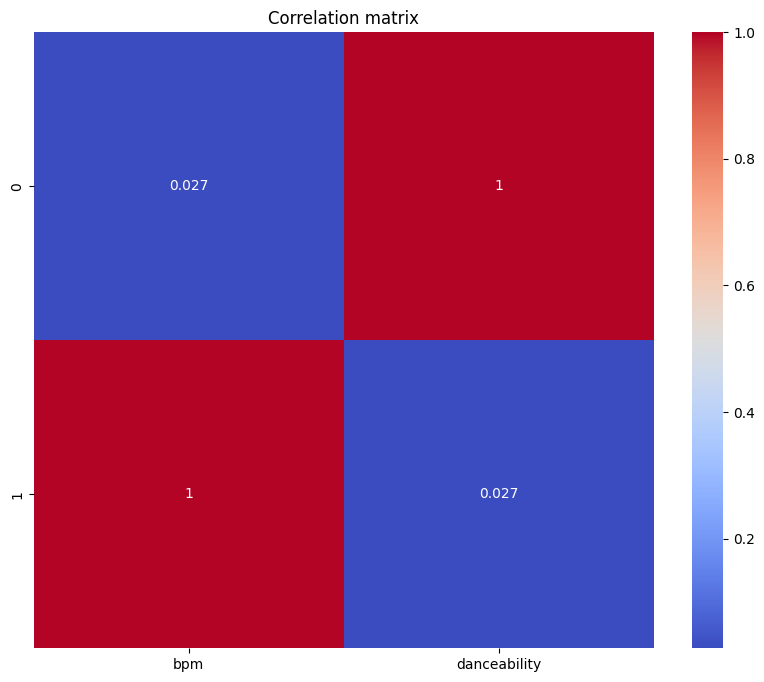

23/12/13 21:48:13 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1038446 ms exceeds timeout 120000 ms
23/12/13 21:48:13 WARN SparkContext: Killing executors is not supported by current scheduler.
23/12/13 22:05:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [86]:
correlation= df_correlation.select(corr('bpm', 'danceability')).collect()[0][0]
print(correlation)

# Create a pandas DataFrame for the heatmap
correlation_matrix = pd.DataFrame({'bpm': ['bpm', 'danceability'],
                                    'danceability': [1, correlation],
                                    'bpm': [correlation, 1]})
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.title("Correlation matrix")

There is a positive but low correlation between bpm and danceability. One issue however is that danceability is a cultural construct, so it varies from country to country, and even between regions. Anecdotically, as a colombian, I would be hardly pressed to consider "The Real Slim Shady" as a danceable track.

Culturally speaking, genre should also be taken into account, as well as lyric content, as both might affect whether people will dance to a song in different places. Other research shows, on the other hand, that most popular dance music in the last half-century tends to hover towards a bpm count slightly higher than the regular human heartbeat (around 80 bpm), but not too high to double it. This seems to match the data presented here, and also explains why it would be hard to find a correlation through standard methods, as such behavior would be non-linear at best.
